In [1]:
import csv
import numpy as np
import os
import pandas as pd
import scipy.interpolate
import sklearn.metrics
import sys
sys.path.append("../src")
import localmodule


if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO


from matplotlib import pyplot as plt
%matplotlib inline

# Define constants.
dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_units = len(units)
n_trials = 10


In [2]:
n_val_trials = 1

model_names = [
    "icassp-convnet", "icassp-convnet_aug-all-but-noise", "icassp-convnet_aug-all", 
    "icassp-ntt-convnet", "icassp-ntt-convnet_aug-all-but-noise", "icassp-ntt-convnet_aug-all",
    "pcen-convnet", "pcen-convnet_aug-all-but-noise", "pcen-convnet_aug-all",
    "icassp-add-convnet", "icassp-add-convnet_aug-all-but-noise", "icassp-add-convnet_aug-all",
    "pcen-add-convnet", "pcen-add-convnet_aug-all-but-noise", "pcen-add-convnet_aug-all",
    "pcen-ntt-convnet_aug-all-but-noise", "pcen-ntt-convnet_aug-all",
    "pcen-addntt-convnet_aug-all-but-noise",
]

n_models = len(model_names)
model_val_accs = {}
model_test_accs = {}
    
# Loop over models.
for model_id, model_name in enumerate(model_names):

    model_dir = os.path.join(models_dir, model_name)
    model_val_accs[model_name] = np.zeros((6,))
    model_test_accs[model_name] = np.zeros((6,))

    for test_unit_id in range(6):

        test_unit_str = units[test_unit_id]
        test_unit_dir = os.path.join(model_dir, test_unit_str)
        
        
        # TRIAL SELECTION
        val_accs = []
        for trial_id in range(n_trials):
            trial_str = "trial-" + str(trial_id)
            trial_dir = os.path.join(test_unit_dir, trial_str)
            history_name = "_".join([
                dataset_name,
                model_name,
                test_unit_str,
                trial_str,
                "history.csv"
            ])
            history_path = os.path.join(
                trial_dir, history_name)
            try:
                history_df = pd.read_csv(history_path)
                val_acc = max(history_df["Validation accuracy (%)"])
            except:
                val_acc = 0.0
            val_accs.append(val_acc)

        val_accs = np.array(val_accs)
        trial_id = np.argmax(val_accs)

        
        # VALIDATION SET EVALUATION
        trial_str = "trial-" + str(trial_id)
        trial_dir = os.path.join(test_unit_dir, trial_str)
        
        fns, fps, tns, tps = [], [], [], []
        validation_units = localmodule.fold_units()[test_unit_id][2]

        for val_unit_str in validation_units:
            predictions_name = "_".join([
                dataset_name,
                model_name,
                "test-" + test_unit_str,
                trial_str,
                "predict-" + val_unit_str,
                "clip-predictions.csv"
            ])
            prediction_path = os.path.join(
                trial_dir, predictions_name)

            # Load prediction.
            with open(prediction_path, 'r') as f:
                reader = csv.reader(f)
                rows = list(reader)
            rows = [",".join(row) for row in rows]
            rows = rows[1:]
            rows = "\n".join(rows)

            # Parse rows with correct header.
            df = pd.read_csv(StringIO(rows),
                names=[
                    "Dataset",
                    "Test unit",
                    "Prediction unit",
                    "Timestamp",
                    "Center Freq (Hz)",
                    "Augmentation",
                    "Key",
                    "Ground truth",
                    "Predicted probability"])
            y_pred = np.array(df["Predicted probability"])
            y_pred = (y_pred > 0.5).astype('int')

            # Load ground truth.
            y_true = np.array(df["Ground truth"])
            
            # Compute confusion matrix.
            tn, fp, fn, tp = sklearn.metrics.confusion_matrix(
                y_true, y_pred).ravel()
            
            tns.append(tn)
            fps.append(fp)
            fns.append(fn)
            tps.append(tp)


        tn = sum(tns)
        tp = sum(tps)
        fn = sum(fns)
        fp = sum(fps)
        val_acc = 100 * (tn+tp) / (tn+tp+fn+fp)
        model_val_accs[model_name][test_unit_id] = val_acc

        
        # TEST SET EVALUATION
        trial_dir = os.path.join(
            test_unit_dir, trial_str)
        predictions_name = "_".join([
            dataset_name,
            model_name,
            "test-" + test_unit_str,
            trial_str,
            "predict-" + test_unit_str,
            "clip-predictions.csv"
        ])
        prediction_path = os.path.join(
            trial_dir, predictions_name)
        
        # Load prediction.
        with open(prediction_path, 'r') as f:
            reader = csv.reader(f)
            rows = list(reader)
        rows = [",".join(row) for row in rows]
        rows = rows[1:]
        rows = "\n".join(rows)

        # Parse rows with correct header.
        df = pd.read_csv(StringIO(rows),
            names=[
                "Dataset",
                "Test unit",
                "Prediction unit",
                "Timestamp",
                "Center Freq (Hz)",
                "Augmentation",
                "Key",
                "Ground truth",
                "Predicted probability"])
        y_pred = np.array(df["Predicted probability"])
        y_pred = (y_pred > 0.5).astype('int')

        # Load ground truth.
        y_true = np.array(df["Ground truth"])

        # Compute confusion matrix.
        tn, fp, fn, tp = sklearn.metrics.confusion_matrix(
            y_true, y_pred).ravel()

        test_acc = 100 * (tn+tp) / (tn+tp+fn+fp)
        model_test_accs[model_name][test_unit_id] = test_acc

In [4]:
model_diagrams = {
    "icassp-convnet":                       "                  melspec -> log           ",
    "icassp-convnet_aug-all-but-noise":     "         geom  -> melspec -> log           ",
    "icassp-convnet_aug-all":               "(noise + geom) -> melspec -> log           ",
    "icassp-ntt-convnet":                   "                  melspec -> log  -> NTT   ",
    "icassp-ntt-convnet_aug-all-but-noise": "         geom  -> melspec -> log  -> NTT   ",
    "icassp-ntt-convnet_aug-all":           "(noise + geom) -> melspec -> log  -> NTT   ",
    "pcen-convnet":                         "                  melspec -> PCEN          ",
    "pcen_convnet_aug-all-but-noise":       "         geom  -> melspec -> PCEN          ",
    "pcen-convnet_aug-all":                 "(noise + geom) -> melspec -> PCEN          ",
    "icassp-add-convnet":                   "                  melspec -> log  -> CONCAT",
    "icassp-add-convnet_aug-all-but-noise": "         geom  -> melspec -> log  -> CONCAT",
    "icassp-add-convent_aug-all":           "(noise + geom) -> melspec -> log  -> CONCAT",
    "pcen-add-convnet":                     "                  melspec -> PCEN -> CONCAT",
    "pcen-add-convnet_aug-all-but-noise":   "         geom  -> melspec -> PCEN -> CONCAT",
    "pcen-add-convnet_aug-all":             "(noise + geom) -> melspec -> PCEN -> CONCAT",
    "pcen-ntt-convnet_aug-all-but-noise":   "         geom  -> melspec -> PCEN -> NTT   ",
    "pcen-ntt-convnet_aug-all":             "(noise + geom) -> melspec -> PCEN -> NTT   ",
    "pcen-addntt-convnet_aug-all":          "(noise + geom) -> melspec -> PCEN -> AFFINE"}



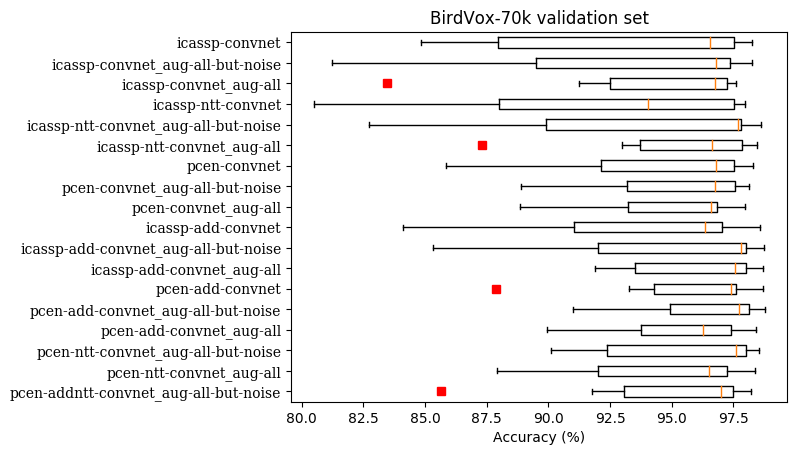

In [5]:
plt.figure(figsize=(9, 6))
plt.rcdefaults()
fig, ax = plt.subplots()
plt.boxplot(np.stack(model_val_accs.values()).T, 0, 'rs', 0)
#plt.ylim((-5.0, 1.0))
plt.setp(ax.get_yticklabels(), family="serif")
ax.set_yticklabels(model_names)
plt.gca().invert_yaxis()
ax.set_xlabel('Accuracy (%)')
ax.set_title('BirdVox-70k validation set')
plt.show()

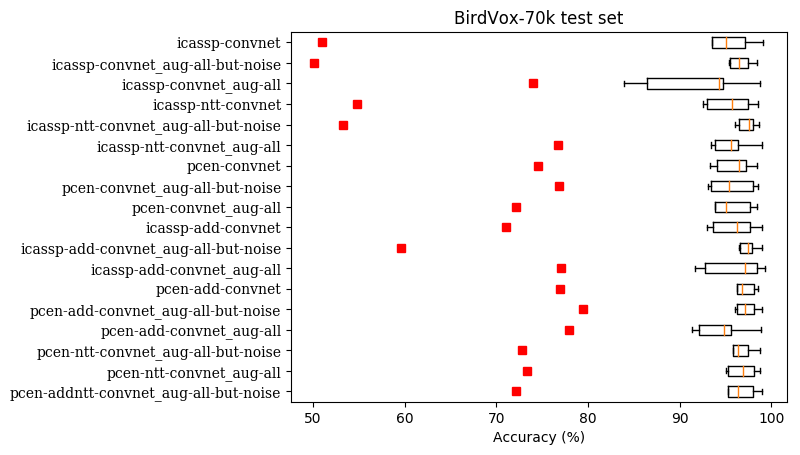

In [4]:
plt.figure(figsize=(9, 6))
plt.rcdefaults()
fig, ax = plt.subplots()
plt.boxplot(np.stack(model_test_accs.values()).T, 0, 'rs', 0)
#plt.ylim((-5.0, 1.0))
plt.setp(ax.get_yticklabels(), family="serif")
ax.set_yticklabels(model_names)
plt.gca().invert_yaxis()
ax.set_xlabel('Accuracy (%)')
ax.set_title('BirdVox-70k test set')
plt.show()

In [5]:
model_test_accs

{'icassp-add-convnet': array([ 71.01845523,  95.43340381,  98.93558652,  97.03647416,
         93.00918836,  97.9602281 ]),
 'icassp-add-convnet_aug-all': array([ 77.06766917,  96.15221987,  99.26478657,  98.49924012,
         98.05513017,  91.6873812 ]),
 'icassp-add-convnet_aug-all-but-noise': array([ 59.60355434,  97.09302326,  98.9739932 ,  97.74886018,
         96.43950995,  98.00409417]),
 'icassp-convnet': array([ 50.99111415,  93.48837209,  99.10018655,  96.58054711,
         93.49157734,  97.29492616]),
 'icassp-convnet_aug-all': array([ 73.95762133,  94.77801268,  98.76549984,  94.57636778,
         83.8820827 ,  94.04152654]),
 'icassp-convnet_aug-all-but-noise': array([ 50.0683527 ,  97.05073996,  98.46373313,  95.82066869,
         95.42113323,  97.60929961]),
 'icassp-ntt-convnet': array([ 54.81886535,  94.32346723,  98.60089981,  97.53039514,
         92.58805513,  97.19988302]),
 'icassp-ntt-convnet_aug-all': array([ 76.74299385,  96.0359408 ,  99.02885987,  93.43655015

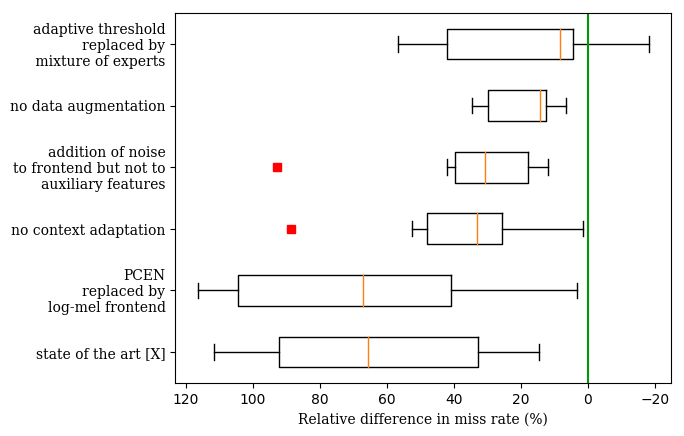

[ 79.46001367  97.05073996  98.99593987  98.44224924  97.19754977
  96.00087732]
[ 73.95762133  94.77801268  98.76549984  94.57636778  83.8820827
  94.04152654]


In [25]:
ablation_reference_name = "pcen-add-convnet_aug-all-but-noise"
ablation_names = [
    "pcen-ntt-convnet_aug-all-but-noise",
    "pcen-add-convnet",
    "pcen-add-convnet_aug-all",
    "pcen-convnet_aug-all-but-noise",
    "icassp-convnet_aug-all-but-noise",
    "icassp-convnet_aug-all"
]
reference_val_accs = model_val_accs[ablation_reference_name]
ablation_val_accs = [
    100 * (reference_val_accs - model_val_accs[name]) / (100 - reference_val_accs)
    for name in ablation_names]

plt.figure(figsize=(9, 6))
plt.rcdefaults()
fig, ax = plt.subplots()
plt.boxplot(np.array(ablation_val_accs).T, 0, 'rs', 0)
plt.setp(ax.get_yticklabels(), family="serif")
ax.set_yticklabels([
    "adaptive threshold\nreplaced by\n mixture of experts",
    "no data augmentation",
    "addition of noise\nto frontend but not to\nauxiliary features",
    "no context adaptation",
    "PCEN\nreplaced by\nlog-mel frontend",
    "state of the art [X]"])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
ax.set_xlabel('Relative difference in miss rate (%)', family="serif")
plt.axvline(0.0, color="#009900")
plt.show()

reference_test_accs = model_test_accs[ablation_reference_name]
print(reference_test_accs)
baseline_test_accs = model_test_accs["icassp-convnet_aug-all"]
print(baseline_test_accs)

In [277]:
n_trials = 10
report = {}

for model_name in model_names[:2]:

    model_dir = os.path.join(models_dir, model_name)


    # Initialize dictionaries
    model_report = {
        "validation": {},
        "test_cv-acc_th=0.5": {}
    }

    # Initialize matrix of validation accuracies.
    val_accs = np.zeros((n_units, n_trials))
    val_tps = np.zeros((n_units, n_trials))
    val_tns = np.zeros((n_units, n_trials))
    val_fps = np.zeros((n_units, n_trials))
    val_fns = np.zeros((n_units, n_trials))
    
    test_accs = np.zeros((n_units, n_trials))
    test_tps = np.zeros((n_units, n_trials))
    test_tns = np.zeros((n_units, n_trials))
    test_fps = np.zeros((n_units, n_trials))
    test_fns = np.zeros((n_units, n_trials))


    # Loop over test units.
    for test_unit_id, test_unit_str in enumerate(units):


        # Define directory for test unit.
        test_unit_dir = os.path.join(model_dir, test_unit_str)


        # Retrieve fold such that unit_str is in the test set.
        folds = localmodule.fold_units()
        fold = [f for f in folds if test_unit_str in f[0]][0]
        test_units = fold[0]
        validation_units = fold[2]


        # Loop over trials.
        for trial_id in range(n_trials):


            # Define directory for trial.
            trial_str = "trial-" + str(trial_id)
            trial_dir = os.path.join(test_unit_dir, trial_str)


            # Initialize.
            break_switch = False
            val_fn = 0
            val_fp = 0
            val_tn = 0
            val_tp = 0


            # Loop over validation units.
            for val_unit_str in validation_units:

                predictions_name = "_".join([
                    dataset_name,
                    model_name,
                    "test-" + test_unit_str,
                    "trial-" + str(trial_id),
                    "predict-" + val_unit_str,
                    "clip-predictions.csv"
                ])
                prediction_path = os.path.join(
                    trial_dir, predictions_name)

                # Load prediction.
                csv_file = pd.read_csv(prediction_path)
                
                # Parse prediction.
                if model_name == "icassp-convnet_aug-all":
                    y_pred = np.array(csv_file["Predicted probability"])
                    y_true = np.array(csv_file["Ground truth"])
                elif model_name == "pcen-add-convnet_aug-all-but-noise":
                    with open(prediction_path, 'r') as f:
                        reader = csv.reader(f)
                        rows = list(reader)
                    rows = [",".join(row) for row in rows]
                    rows = rows[1:]
                    rows = "\n".join(rows)

                    # Parse rows with correct header.
                    df = pd.read_csv(StringIO(rows),
                        names=[
                            "Dataset",
                            "Test unit",
                            "Prediction unit",
                            "Timestamp",
                            "Center Freq (Hz)",
                            "Augmentation",
                            "Key",
                            "Ground truth",
                            "Predicted probability"])
                    y_pred = np.array(df["Predicted probability"])
                    y_true = np.array(df["Ground truth"])
                    
                # Threshold.
                y_pred = (y_pred > 0.5).astype('int')

                # Check that CSV file is not corrupted.
                if len(y_pred) == 0:
                    break_switch = True
                    break

                # Compute confusion matrix.
                tn, fp, fn, tp = sklearn.metrics.confusion_matrix(
                    y_true, y_pred).ravel()

                val_fn = val_fn + fn
                val_fp = val_fp + fp
                val_tn = val_tn + tn
                val_tp = val_tp + tp


            if not break_switch:
                val_acc = (val_tn+val_tp) / (val_fn+val_fp+val_tn+val_tp)
            else:
                val_fn = 0
                val_fp = 0
                val_tn = 0
                val_tp = 0
                val_acc = 0.0
            
            val_fns[test_unit_id, trial_id] = val_fn
            val_fps[test_unit_id, trial_id] = val_fp
            val_tns[test_unit_id, trial_id] = val_tn
            val_tps[test_unit_id, trial_id] = val_tp
            val_accs[test_unit_id, trial_id] = val_acc


            # Initialize.
            predictions_name = "_".join([
                dataset_name,
                model_name,
                "test-" + test_unit_str,
                "trial-" + str(trial_id),
                "predict-" + test_unit_str,
                "clip-predictions.csv"
            ])
            prediction_path = os.path.join(
                trial_dir, predictions_name)


            with open(prediction_path, 'r') as f:
                reader = csv.reader(f)
                rows = list(reader)
            rows = [",".join(row) for row in rows]
            rows = rows[1:]
            rows = "\n".join(rows)

            # Parse rows with correct header.
            df = pd.read_csv(StringIO(rows),
                names=[
                    "Dataset",
                    "Test unit",
                    "Prediction unit",
                    "Timestamp",
                    "Center Freq (Hz)",
                    "Augmentation",
                    "Key",
                    "Ground truth",
                    "Predicted probability"])
            y_pred = np.array(df["Predicted probability"])
            y_pred = (y_pred > 0.5).astype('int')
            y_true = np.array(df["Ground truth"])

            # Check that CSV file is not corrupted.
            if len(y_pred) == 0:
                test_tn, test_fp, test_fn, test_tp = 0, 0, 0, 0
                test_acc = 0.0
            else:
                # Load ground truth.
                y_true = np.array(df["Ground truth"])
                # Compute confusion matrix.
                test_tn, test_fp, test_fn, test_tp =\
                    sklearn.metrics.confusion_matrix(
                        y_true, y_pred).ravel()
                test_acc = (test_tn+test_tp) / (test_fn+test_fp+test_tn+test_tp)


            test_fns[test_unit_id, trial_id] = test_fn
            test_fps[test_unit_id, trial_id] = test_fp
            test_tns[test_unit_id, trial_id] = test_tn
            test_tps[test_unit_id, trial_id] = test_tp
            test_accs[test_unit_id, trial_id] = test_acc 
            
    model_report["validation"]["FN"] = test_fn
    model_report["validation"]["FP"] = test_fp
    model_report["validation"]["TN"] = test_tn
    model_report["validation"]["TP"] = test_tp
    model_report["validation"]["accuracy"] = val_accs
    
    best_trials = np.argsort(model_report["validation"]["accuracy"], axis=1)
    model_report["validation"]["best_trials"] = best_trials
    
    model_report["test_cv-acc_th=0.5"]["FN"] = test_fns
    model_report["test_cv-acc_th=0.5"]["FP"] = test_fps
    model_report["test_cv-acc_th=0.5"]["TN"] = test_tns
    model_report["test_cv-acc_th=0.5"]["TP"] = test_tps
    model_report["test_cv-acc_th=0.5"]["accuracy"] = test_accs

    
    cv_accs = []
    for eval_trial_id in range(5):
        cv_fn = 0
        cv_fp = 0
        cv_tn = 0
        cv_tp = 0

        for test_unit_id, test_unit_str in enumerate(units):

            best_trials = model_report["validation"]["best_trials"]
            unit_best_trials = best_trials[test_unit_id, -5:]
            unit_best_trials = sorted(unit_best_trials)
            trial_id = unit_best_trials[eval_trial_id]

            cv_fn = cv_fn + model_report["test_cv-acc_th=0.5"]["FN"][test_unit_id, trial_id]
            cv_fp = cv_fp + model_report["test_cv-acc_th=0.5"]["FP"][test_unit_id, trial_id]
            cv_tn = cv_tn + model_report["test_cv-acc_th=0.5"]["TN"][test_unit_id, trial_id]
            cv_tp = cv_tp + model_report["test_cv-acc_th=0.5"]["TP"][test_unit_id, trial_id]

        cv_acc = (cv_tn+cv_tp) / (cv_tn+cv_tp+cv_fn+cv_fp)
        cv_accs.append(cv_acc)

        
    model_report["test_cv-acc_th=0.5"]["global_acc"] = np.array(cv_accs)
    report[model_name] = model_report
    
    print(model_name, ": acc = {:5.2f}% ± {:3.1f}".format(
        100*np.mean(report[model_name]['test_cv-acc_th=0.5']['global_acc']),
        100*np.std(report[model_name]['test_cv-acc_th=0.5']['global_acc'])))
    
    
#print(report['icassp-convnet_aug-all']['test_cv-acc_th=0.5']['global_acc'])
#print(report['pcen-add-convnet_aug-all-but-noise']['test_cv-acc_th=0.5']['global_acc'])

icassp-convnet : acc = 84.22% ± 5.5
icassp-convnet_aug-all-but-noise : acc = 84.71% ± 7.5


In [6]:
icassp_accs = report['icassp-convnet_aug-all']['test_cv-acc_th=0.5']['global_acc']
print("ICASSP 2018: acc = {:5.2f}% ± {:3.1f}".format(100*np.mean(icassp_accs), 100*np.std(icassp_accs)))

spl_accs = report['pcen-add-convnet_aug-all-but-noise']['test_cv-acc_th=0.5']['global_acc']
print("SPL 2018:    acc = {:5.2f}% ± {:3.1f}".format(100*np.mean(spl_accs), 100*np.std(spl_accs)))

NameError: name 'report' is not defined

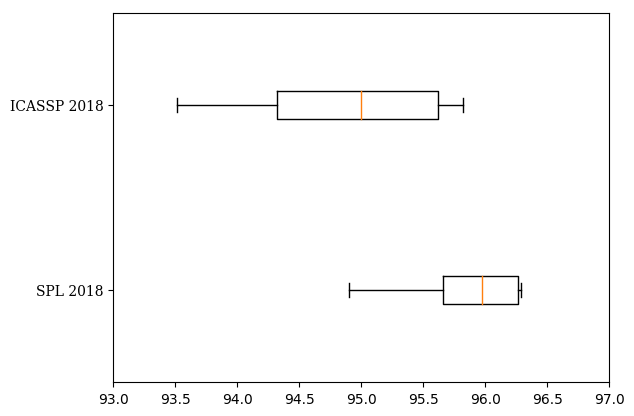

In [268]:
plt.figure(figsize=(6, 3))
fig, ax = plt.subplots()
plt.rcdefaults()
plt.boxplot(np.array([100*icassp_accs, 100*spl_accs]).T, 0, 'rs', 0);
plt.xlim([93.0, 97.0])
plt.setp(ax.get_yticklabels(), family="serif")
ax.set_yticklabels(["ICASSP 2018", "SPL 2018"])
plt.gca().invert_yaxis()

In [174]:
print(scipy.stats.ttest_ind(icassp_accs, spl_accs))

Ttest_indResult(statistic=-1.9479807165667256, pvalue=0.087263998885233063)


In [178]:
np.min(icassp_accs), np.max(icassp_accs)

(0.93514490706739728, 0.95815208180328792)

In [180]:
np.min(spl_accs), np.max(spl_accs)

(0.94901417998983106, 0.96288345291226485)

In [239]:

icassp_fold_accs = report['icassp-convnet_aug-all']['validation']["accuracy"]
spl_fold_accs = report['pcen-add-convnet_aug-all-but-noise']['validation']["accuracy"]
print(np.mean(np.max(icassp_fold_accs, axis=1)), np.mean(np.max(spl_fold_accs, axis=1)))

0.954919296987 0.964616622329
